In [1]:
###################
# LIBRARIES
###################

import joblib
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

In [2]:
matplotlib.use("Qt5Agg")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 170)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, cross_validate, RandomizedSearchCV, validation_curve, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, plot_confusion_matrix


In [4]:
###################
# FUNCTIONS
###################


def standart_scaler(col_name):
    return (col_name - col_name.mean()) / col_name.std()

def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

def cat_summary(dataframe, col_name, plot=False):

    if dataframe[col_name].dtypes == "bool":
        dataframe[col_name] = dataframe[col_name].astype(int)

        print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                            "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
        print("##########################################")

        if plot:
            sns.countplot(x=dataframe[col_name], data=dataframe)
            plt.show(block=True)
    else:
        print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                            "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
        print("##########################################")

        if plot:
            sns.countplot(x=dataframe[col_name], data=dataframe)
            plt.show(block=True)

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist()
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

def grab_col_names(dataframe, cat_th=10,  car_th=20):
    """
    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.

    Parameters
    ----------
    dataframe: dataframe
        değişken isimleri alınmak istenen dataframe'dir.
    cat_th: int, float
        numerik fakat kategorik olan değişkenler için sınıf eşik değeri
    car_th: int, float
        kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    -------
    cat_cols: list
        Kategorik değişken listesi
    num_cols: list
        Numerik değişken listesi
    cat_but_car: list
        Kategorik görünümlü kardinal değişken listesi

    Notes
    ------
    cat_cols + num_cols + cat_but_car = toplam değişken sayısı
    num_but_cat cat_cols'un içerisinde.

    """
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["category", "object", "bool"]]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < 10 and dataframe[col].dtypes in ["int", "float"]]

    cat_but_car = [col for col in dataframe.columns if
                   dataframe[col].nunique() > 20 and str(dataframe[col].dtypes) in ["category", "object"]]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ["int", "float"]]
    num_cols = [col for col in num_cols if col not in cat_cols]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean(),
                        "Count": dataframe[categorical_col].value_counts(),
                        "Ratio": 100 * dataframe[categorical_col].value_counts() / len(dataframe)}), end="\n\n\n")

def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

def high_correlated_cols(dataframe, plot=False, corr_th=0.90):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (15, 15)})
        sns.heatmap(corr, cmap="RdBu")
        plt.show()
    return drop_list

def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = round(low_limit, 0)
    dataframe.loc[(dataframe[variable] > up_limit), variable] = round(up_limit, 0)

def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers

def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()
    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)
    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns
    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")

def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df

def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column], color="g")
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return


In [5]:
## Variable Information ##

# CustomerId : Müşteri İd’si
# Gender : Cinsiyet
# SeniorCitizen : Müşterinin yaşlı olup olmadığı (1, 0)
# Partner : Müşterinin bir ortağı olup olmadığı (Evet, Hayır) ? Evli olup olmama
# Dependents : Müşterinin bakmakla yükümlü olduğu kişiler olup olmadığı (Evet, Hayır) (Çocuk, anne, baba, büyükanne)
# tenure : Müşterinin şirkette kaldığı ay sayısı
# PhoneService : Müşterinin telefon hizmeti olup olmadığı (Evet, Hayır)
# MultipleLines : Müşterinin birden fazla hattı olup olmadığı (Evet, Hayır, Telefon hizmeti yok)
# InternetService : Müşterinin internet servis sağlayıcısı (DSL, Fiber optik, Hayır)
# OnlineSecurity : Müşterinin çevrimiçi güvenliğinin olup olmadığı (Evet, Hayır, İnternet hizmeti yok)
# OnlineBackup : Müşterinin online yedeğinin olup olmadığı (Evet, Hayır, İnternet hizmeti yok)
# DeviceProtection : Müşterinin cihaz korumasına sahip olup olmadığı (Evet, Hayır, İnternet hizmeti yok)
# TechSupport : Müşterinin teknik destek alıp almadığı (Evet, Hayır, İnternet hizmeti yok)
# StreamingTV : Müşterinin TV yayını olup olmadığı (Evet, Hayır, İnternet hizmeti yok) Müşterinin, bir üçüncü taraf sağlayıcıdan televizyon programları yayınlamak için İnternet hizmetini kullanıp kullanmadığını gösterir
# StreamingMovies : Müşterinin film akışı olup olmadığı (Evet, Hayır, İnternet hizmeti yok) Müşterinin bir üçüncü taraf sağlayıcıdan film akışı yapmak için İnternet hizmetini kullanıp kullanmadığını gösterir
# Contract : Müşterinin sözleşme süresi (Aydan aya, Bir yıl, İki yıl)
# PaperlessBilling : Müşterinin kağıtsız faturası olup olmadığı (Evet, Hayır)
# PaymentMethod : Müşterinin ödeme yöntemi (Elektronik çek, Posta çeki, Banka havalesi (otomatik), Kredi kartı (otomatik))
# MonthlyCharges : Müşteriden aylık olarak tahsil edilen tutar
# TotalCharges : Müşteriden tahsil edilen toplam tutar
# Churn : Müşterinin kullanıp kullanmadığı (Evet veya Hayır) - Geçen ay veya çeyreklik içerisinde ayrılan müşteriler

In [6]:
# Reading data

telco = pd.read_csv("Telco-Customer-Churn.csv")

df = telco.copy()

In [7]:
check_df(df)

##################### Shape #####################
(7043, 21)
##################### Types #####################
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object
##################### Head #####################
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService     MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport  \
0  7590-VHVEG  Female              0     Yes         No       1    

In [8]:
## Total Charges should be numeric
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

In [9]:
## There is only 11 NA values, it is OK to drop them.
df.dropna(inplace=True)

In [10]:
df["Churn"] = df["Churn"].apply(lambda x: 1 if x == "Yes" else 0)

In [11]:
## Dealing with imbalanced dataset:
# I'll use bootstrapping but gotta respect the frequency difference between Churn levels
## To avoid data leakage to testing, I'll not concatenate.

train, test = train_test_split(df, test_size=0.2, stratify=df.Churn, random_state=26)

train_churned = train.loc[train["Churn"] == 1, :]

sampled_within = train_churned.sample(n=(4130-1495), replace=True, random_state=26)

train_new = train.append(sampled_within, ignore_index=True)

C:\Users\psyen\AppData\Local\Temp\ipykernel_15880\754681087.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_new = train.append(sampled_within, ignore_index=True)


In [12]:
## Defining a function to create new column

def pay_auto(x):
    if x == "Bank transfer (automatic)":
        return 1
    elif x == "Credit card (automatic)":
        return 1
    else:
        return 0

In [13]:
## Is payment auto?
train_new["IsPayAuto"] = train_new.loc[:, "PaymentMethod"].apply(lambda x: pay_auto(x))

In [14]:
## Number of services
train_new["TotalServices"] = (train_new[['PhoneService', 'InternetService', 'OnlineSecurity',
                                       'OnlineBackup', 'DeviceProtection', 'TechSupport',
                                       'StreamingTV', 'StreamingMovies']]== 'Yes').sum(axis=1)

In [15]:
## Any protection?
train_new["NEW_noProt"] = train_new.apply(lambda x: 1 if (x["OnlineBackup"] != "Yes") or (x["DeviceProtection"] != "Yes") or (x["TechSupport"] != "Yes") else 0, axis=1)

In [16]:
## Dropping the redundant column

train_new.drop("PhoneService", axis=1, inplace=True)

In [17]:
cat_, num_, cat_but_car_ = grab_col_names(train_new)

Observations: 8260
Variables: 23
cat_cols: 14
num_cols: 2
cat_but_car: 1
num_but_cat: 0


In [18]:
cat_cols = [col for col in train_new if train_new[col].dtypes == "object" and col not in cat_but_car_]

In [19]:
manual_cols = ["StreamingMovies", "StreamingTV", "TechSupport", "DeviceProtection", "OnlineBackup", "OnlineSecurity", "InternetService"]

In [20]:
train_new = one_hot_encoder(train_new, [col for col in train_new if str(col) not in manual_cols and str(col) in cat_cols], True)
train_new = one_hot_encoder(train_new, manual_cols, False)

In [21]:
train_new.drop([col for col in train_new if str(col).endswith("No internet service")], axis=1, inplace=True)
train_new.drop("InternetService_No", axis=1, inplace=True)

In [22]:
test["IsPayAuto"] = test.loc[:, "PaymentMethod"].apply(lambda x: pay_auto(x))
test["TotalServices"] = (test[['PhoneService', 'InternetService', 'OnlineSecurity',
                                       'OnlineBackup', 'DeviceProtection', 'TechSupport',
                                       'StreamingTV', 'StreamingMovies']]== 'Yes').sum(axis=1)
test["NEW_noProt"] = test.apply(lambda x: 1 if (x["OnlineBackup"] != "Yes") or (x["DeviceProtection"] != "Yes") or (x["TechSupport"] != "Yes") else 0, axis=1)
test.drop("PhoneService", axis=1, inplace=True)

In [23]:
cat_, num_, cat_but_car_ = grab_col_names(test)
cat_cols = [col for col in test if test[col].dtypes == "object" and col not in cat_but_car_]

Observations: 1407
Variables: 23
cat_cols: 14
num_cols: 2
cat_but_car: 1
num_but_cat: 0


In [24]:
test = one_hot_encoder(test, [col for col in test if str(col) not in manual_cols and str(col) in cat_cols], True)
test = one_hot_encoder(test, manual_cols, False)

test.drop([col for col in test if str(col).endswith("No internet service")], axis=1, inplace=True)
test.drop("InternetService_No", axis=1, inplace=True)

In [25]:
X = train_new.drop(["Churn", "customerID"], axis=1)
y = train_new["Churn"]
X_test = test.drop(["Churn", "customerID"], axis=1)
y_test = test["Churn"]

In [26]:
## Logistic Regression

lr_model = LogisticRegression(random_state=26, max_iter=1000, class_weight="balanced").fit(X, y)

In [27]:
cv_results = cross_validate(lr_model,
                           X, y,
                           cv=5,
                           scoring=["f1", "accuracy", "precision", "recall", "roc_auc"])

In [28]:
print(cv_results["test_f1"].mean())
print(cv_results['test_accuracy'].mean())
print(cv_results['test_precision'].mean())
print(cv_results['test_recall'].mean())
print(cv_results["test_roc_auc"].mean())

0.7698709161394767
0.7628329297820824
0.7476967834472535
0.7934624697336561
0.8436560863931899


In [29]:
y_pred = lr_model.predict(X_test)

In [30]:
print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 3)}")
print(f"Recall: {round(recall_score(y_pred,y_test),3)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 3)}")
print(f"F1: {round(f1_score(y_pred,y_test), 3)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 3)}")

Accuracy: 0.753
Recall: 0.524
Precision: 0.786
F1: 0.629
Auc: 0.715


D:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


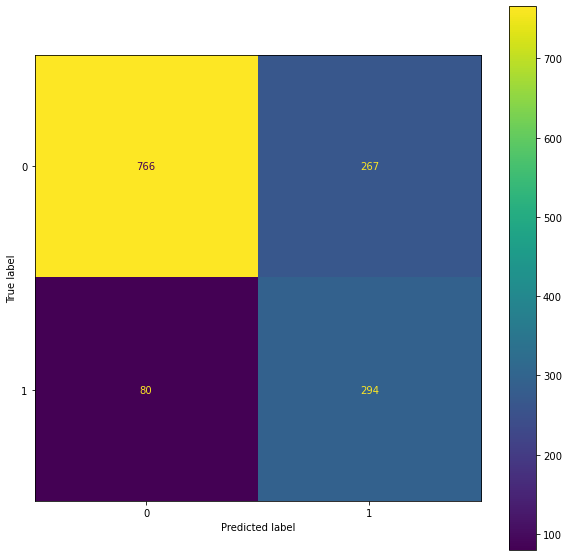

In [31]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
g = fig.add_subplot(1,1,1)
plot_confusion_matrix(lr_model, X_test, y_test, ax=g)

In [32]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.74      0.82      1033
           1       0.52      0.79      0.63       374

    accuracy                           0.75      1407
   macro avg       0.71      0.76      0.72      1407
weighted avg       0.80      0.75      0.77      1407



Fitting 5 folds for each of 200 candidates, totalling 1000 fits


D:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Scoring for different class weights')

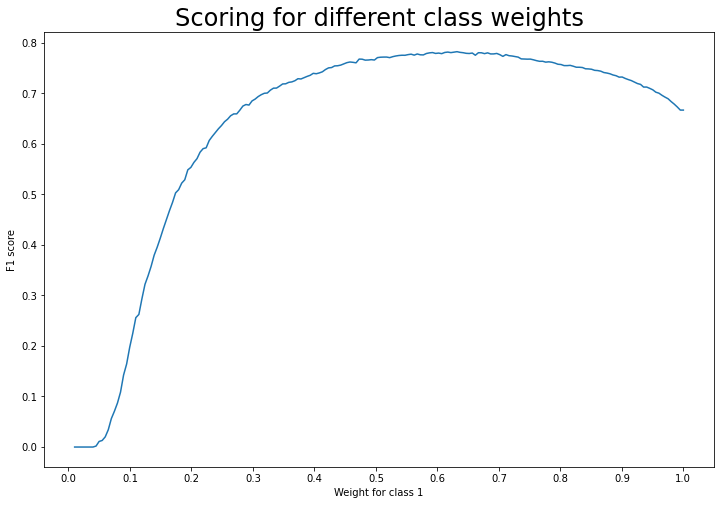

In [33]:
## To take a different approach towards imbalance of the data in respect to churn
## we may change the class_weight accordingly and search through best values for F1 score

lr = LogisticRegression(max_iter=1000, random_state=26)

#Setting the range for class weights
weights = np.linspace(0.0,0.99,200)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X, y)

#Ploting the score for different values of weight
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)

D:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


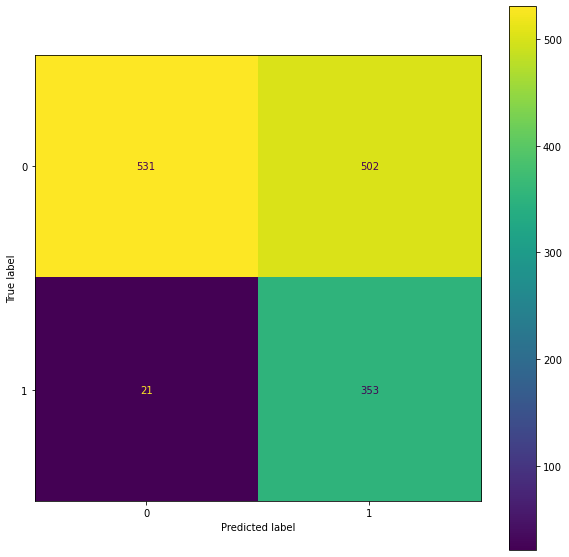

In [34]:
## Or, we can change class_weights manually and give more importance to churn
## depending on the business approach

#importing and training the model
lr = LogisticRegression(max_iter=1000, random_state=26, class_weight={0: 0.25, 1: 0.75})
lr.fit(X, y)

# Predicting on the test data
pred_test = lr.predict(X_test)

%matplotlib inline

fig = plt.figure(figsize=(10, 10))
g = fig.add_subplot(1,1,1)
plot_confusion_matrix(lr, X_test, y_test, ax=g)

In [35]:
len(train_new.columns)

34

In [36]:
## LGBM
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(random_state=26, class_weight="balanced").fit(X,y)

In [37]:
cv_results = cross_validate(lgbm, X, y, cv=5, scoring=["f1", "recall", "precision", "accuracy", "roc_auc"])

In [38]:
print(cv_results["test_f1"].mean())
print(cv_results['test_accuracy'].mean())
print(cv_results['test_precision'].mean())
print(cv_results['test_recall'].mean())
print(cv_results["test_roc_auc"].mean())

0.8435585950822212
0.8340193704600484
0.7972142645005257
0.8961259079903148
0.9074058005851006


In [39]:
y_pred = lgbm.predict(X_test)

In [40]:
print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 3)}")
print(f"Recall: {round(recall_score(y_pred,y_test),3)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 3)}")
print(f"F1: {round(f1_score(y_pred,y_test), 3)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 3)}")

Accuracy: 0.77
Recall: 0.551
Precision: 0.725
F1: 0.626
Auc: 0.719


D:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


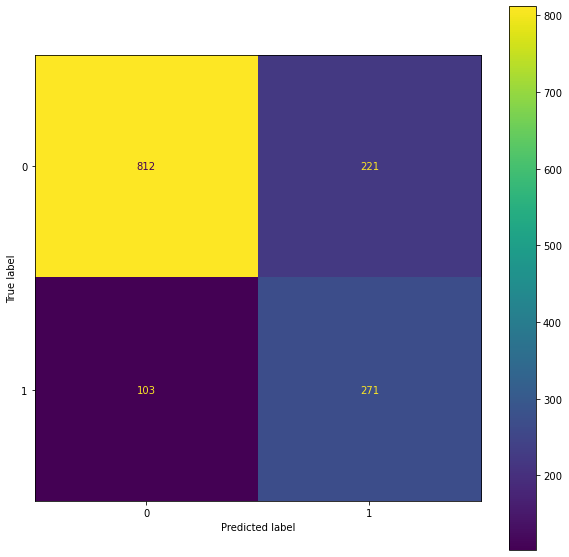

In [41]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
g = fig.add_subplot(1,1,1)
plot_confusion_matrix(lgbm, X_test, y_test, ax=g)

In [42]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.79      0.83      1033
           1       0.55      0.72      0.63       374

    accuracy                           0.77      1407
   macro avg       0.72      0.76      0.73      1407
weighted avg       0.80      0.77      0.78      1407



In [43]:
lgbm_params = {"learning_rate": [0.01, 0.1, 0.2],
               "n_estimators": [2500, 3000, 3500, 4000],
               "colsample_bytree": [0.3, 0.5, 0.7, 1]}

# 300, 500, 800, 1000, 1500, 2000, 

In [44]:
lgbm_best_grid = GridSearchCV(lgbm,
                              lgbm_params,
                              cv=5,
                              n_jobs=-1,
                              verbose=1).fit(X, y)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [45]:
lgbm_best_grid.best_params_

{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'n_estimators': 3500}

In [46]:
lgbm_final = LGBMClassifier(**lgbm_best_grid.best_params_, random_state=26, class_weight="balanced").fit(X, y)

In [47]:
y_pred = lgbm_final.predict(X_test)

In [48]:
print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 3)}")
print(f"Recall: {round(recall_score(y_pred,y_test),3)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 3)}")
print(f"F1: {round(f1_score(y_pred,y_test), 3)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 3)}")

Accuracy: 0.764
Recall: 0.561
Precision: 0.513
F1: 0.536
Auc: 0.695


D:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


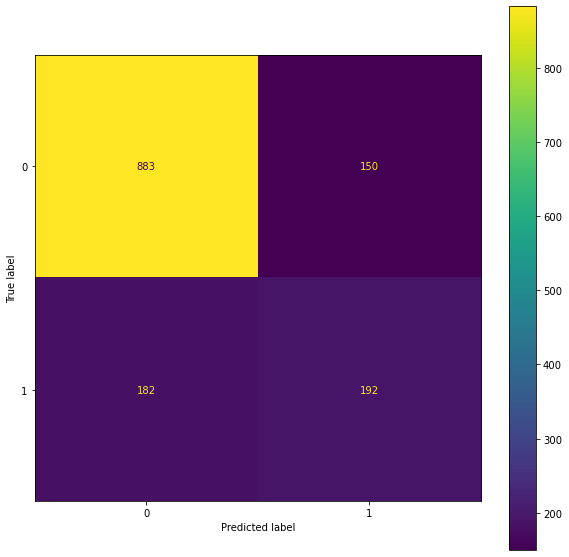

In [49]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
g = fig.add_subplot(1,1,1)
plot_confusion_matrix(lgbm_final, X_test, y_test, ax=g)

In [50]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1033
           1       0.56      0.51      0.54       374

    accuracy                           0.76      1407
   macro avg       0.70      0.68      0.69      1407
weighted avg       0.76      0.76      0.76      1407



In [51]:
#CatBoost
from catboost import CatBoostClassifier

cb_model = CatBoostClassifier(random_state=26, verbose=False, auto_class_weights="Balanced").fit(X, y)

In [52]:
cv_results = cross_validate(cb_model, X, y, cv=5, scoring=["f1", "recall", "precision", "accuracy", "roc_auc"])

In [53]:
print(cv_results["test_f1"].mean())
print(cv_results['test_accuracy'].mean())
print(cv_results['test_precision'].mean())
print(cv_results['test_recall'].mean())
print(cv_results["test_roc_auc"].mean())

0.845554137692561
0.8361985472154962
0.7997972015035636
0.897094430992736
0.9093953180237909


In [54]:
y_pred = cb_model.predict(X_test)

In [55]:
print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 3)}")
print(f"Recall: {round(recall_score(y_pred,y_test),3)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 3)}")
print(f"F1: {round(f1_score(y_pred,y_test), 3)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 3)}")

Accuracy: 0.774
Recall: 0.558
Precision: 0.719
F1: 0.629
Auc: 0.722


In [56]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

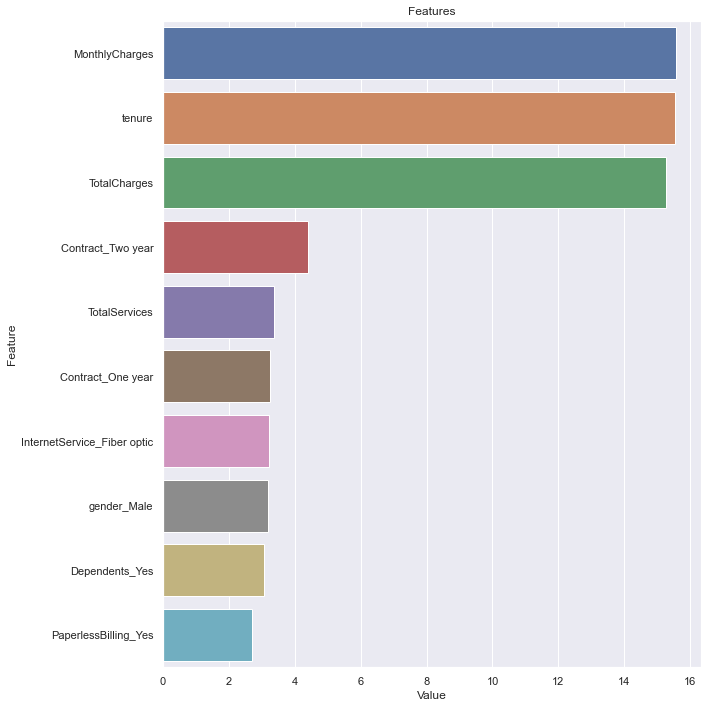

In [57]:
plot_importance(cb_model, X_test, 10, False)

In [ ]:
cb_params = {"iterations": [500, 1000, 1500],
             "learning_rate": [0.01, 0.1, 0.2],
             "depth": [3, 6, 8, 10, 15]}

In [ ]:
cb_best_grid = GridSearchCV(cb_model,
                            cb_params,
                            cv=3,
                            verbose=1).fit(X, y)

In [ ]:
cb_final = cb_model.set_params(**cb_best_grid.best_params_, random_state=26, verbose=False, auto_class_weights="Balanced").fit(X, y)

In [ ]:
y_pred = cb_final.predict(X_test)

In [ ]:
print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 3)}")
print(f"Recall: {round(recall_score(y_pred,y_test),3)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 3)}")
print(f"F1: {round(f1_score(y_pred,y_test), 3)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 3)}")

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
g = fig.add_subplot(1,1,1)
plot_confusion_matrix(cb_model, X_test, y_test, ax=g)

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
g = fig.add_subplot(1,1,1)
plot_confusion_matrix(cb_final, X_test, y_test, ax=g)

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred)
print(report)

In [ ]:
plot_importance(cb_final, X_test, 10, False)